In [1]:
import numpy as np

import sys
import os

os.environ['TOOLBOX_PATH'] = "/PATH/TO/BART/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")
sys.path.append("PATH/TO/TOOLS/")

import struct
import cfl

from copy import deepcopy

from matplotlib import pyplot as plt
from matplotlib import lines as lines
from matplotlib import colors as col
from matplotlib import patches as patches
%matplotlib inline

import toolbox as tools

import pickle5 as pickle
import skimage
import nibabel as nib

In [2]:
from tabulate import tabulate

def tab_metrics(fields, vol_dict, overall_dict):
    
    names = list(overall_dict.keys())
    tab = []
    for r in range(len(names)):
        row = []
        
        row.append(names[r])
        
        for v in range(5):
            
            cur_line = f"{np.real(vol_dict[v][names[r]]):.3f}"
            
            if not np.imag(vol_dict[v][names[r]]) == 0:
                cur_line = cur_line + '+-' + f"{np.imag(vol_dict[v][names[r]]):.3f}"   
            row.append(cur_line)
        
        cur_line = f"{np.real(overall_dict[names[r]]):.3f}"
            
        if not np.imag(overall_dict[names[r]]) == 0:
            cur_line = cur_line + '+-' + f"{np.imag(overall_dict[names[r]]):.3f}"   
        row.append(cur_line)
        
        tab.append(row)
    
    print(tabulate(tab,headers=fields))

In [3]:
# Define folders to load magnitude and phase data from
folder = 'Saved_Recon_Data/TGV_recon_01/'

volunteers = [1,2,3,4,5]

In [4]:
# Load BFFE Flow BH

BFFE_BH = []
BFFE_FB = []
GRE_BH = []
GRE_FB = []

for vol in volunteers:
    
    with open(folder+'flow_BFFE_cv'+str(vol)+'_recon.pickle', 'rb') as handle:
        BFFE_BH.append(pickle.load(handle)['cardiac_peaks'])
    with open(folder+'flow_BFFE_cv'+str(vol)+'_FB_recon.pickle', 'rb') as handle:
        BFFE_FB.append(pickle.load(handle)['cardiac_peaks'])



In [5]:
BH_max = 6000
FB_max = 40000

TGA = np.pi/((np.sqrt(5)+1)/2+7-1)

phases = 25

angles_BH = np.mod(np.arange(0,BH_max)*TGA,2*np.pi)
angles_FB = np.mod(np.arange(0,FB_max)*TGA,2*np.pi)

results = []
rand_subset = []
rand_conv = []

for v in range(5):
    peaks_card = BFFE_BH[v]
    card_labels = tools.binning.generate_bin_labels(peaks_card, 25, BH_max)
    
    sub_list = []
    sub_rand = []
    for i in range(phases):
        val = np.mean(np.sin(angles_BH[card_labels==i]))# + np.mean(np.cos(angles_BH[card_labels==i]))
        sub_list.append(np.abs(val))

        subset = np.random.choice(angles_BH,(card_labels==i).sum())
        val_rand = np.mean(np.sin(subset))# + np.mean(np.cos(subset))
        sub_rand.append(np.abs(val_rand))
    results.append(sub_list)
    rand_subset.append(sub_rand)
    
    s = 0
    for i in range(phases):
        s = s+(card_labels==i).sum()

    s = int(np.round(s/phases))
    res_rand = []
    for i in range(2000):

        subset = np.random.choice(angles_BH,s)
        val_rand = np.mean(np.sin(subset))# + np.mean(np.cos(subset))
        res_rand.append(np.abs(val_rand))

    rand_conv.append(res_rand)

In [6]:
Volunteer_metrics = [{},{},{},{},{}]
Overall_metrics = {}

key1 = "Measured"
key2 = "Random Subset Small"
key3 = "Random Subset"

l = []
r = []
r2 = []
for v in range(5):
    
    m = np.mean(results[v])
    s = np.std(results[v])
    if not v == 2:
        l = l + results[v]
    
    Volunteer_metrics[v][key1] = m + 1j*s
    
    m = np.mean(rand_subset[v])
    s = np.std(rand_subset[v])
    if not v == 2:
        r = r + rand_subset[v]
    
    Volunteer_metrics[v][key2] = m + 1j*s
    
    m = np.mean(rand_conv[v])
    s = np.std(rand_conv[v])
    if not v == 2:
        r2 = r2 + rand_conv[v]
    
    Volunteer_metrics[v][key3] = m + 1j*s

Overall_metrics[key1] = np.mean(l) + 1j*np.std(l)
Overall_metrics[key2] = np.mean(r) + 1j*np.std(r)
Overall_metrics[key3] = np.mean(r2) + 1j*np.std(r2)
    

In [7]:
metrics = {}

fields = ['Spoke Metrics','Subj1','Subj2','Subj3','Subj4','Subj5','Overall']
tab_metrics(fields,Volunteer_metrics,Overall_metrics)
    
    

Spoke Metrics        Subj1         Subj2         Subj3         Subj4         Subj5         Overall
-------------------  ------------  ------------  ------------  ------------  ------------  ------------
Measured             0.034+-0.022  0.061+-0.039  0.100+-0.054  0.056+-0.045  0.035+-0.024  0.047+-0.036
Random Subset Small  0.034+-0.019  0.042+-0.030  0.040+-0.022  0.032+-0.022  0.034+-0.026  0.036+-0.025
Random Subset        0.039+-0.028  0.039+-0.029  0.037+-0.028  0.037+-0.028  0.039+-0.030  0.038+-0.029


In [2]:
gamma = 2*np.pi*42e6

FOV = 0.2
matrix = 101
G=0.01
v = (1,0)

recon_size = 101


angles = np.linspace(0,2*np.pi,157,endpoint=False)

res = FOV/matrix
BW = G*gamma/(2*np.pi)*res


xp = np.arange(-np.ceil(recon_size/2),np.floor(recon_size/2),1)/np.ceil(recon_size/2)*FOV
dk = 1/FOV

X,Y = np.meshgrid(xp,xp)
refk = np.arange(-np.ceil(matrix/2),np.floor(matrix/2),1)*dk
kx = np.outer(refk,np.sin(angles))
ky = np.outer(refk,np.cos(angles))

image = np.zeros_like(X)*1j
image_ref = np.zeros_like(X)*1j

for nkx,nky in zip(kx.flatten(),ky.flatten()):
    ff = np.exp(2*np.pi*1j*(nkx*X + nky*Y))
    image = image + ff * np.exp(1j*1/(2*gamma*G)*np.sqrt((nkx)**2+(nky)**2)*(v[0]*(nkx)+v[1]*(nky)))
    image_ref = image_ref + ff

0.0005414906968626426


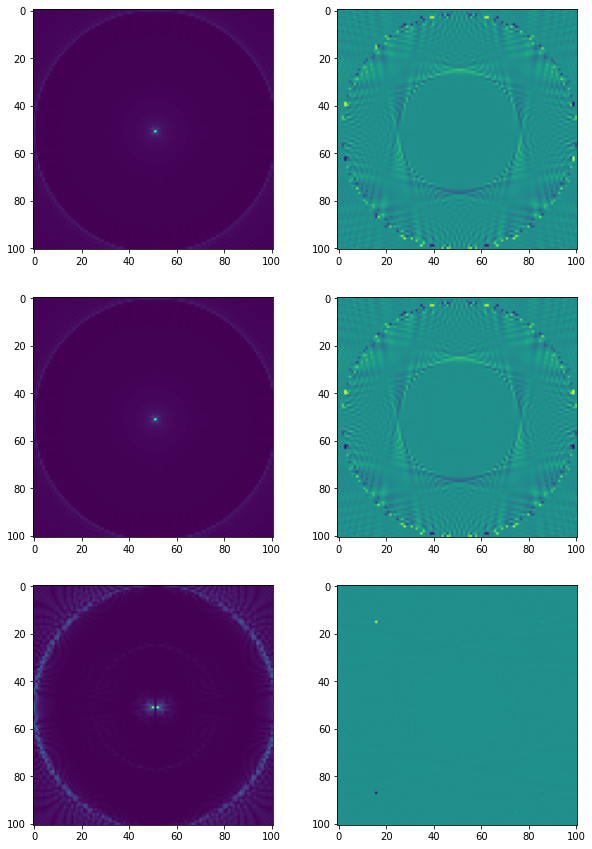

In [3]:
f, a = plt.subplots(3,2, figsize=(10,15))

mag_im = np.abs(image)/np.max(np.abs(image_ref))
mag_ref = np.abs(image_ref)/np.max(np.abs(image_ref))

angle_im = np.angle(image)
angle_im[angle_im>np.pi/2] = angle_im[angle_im>np.pi/2]-np.pi
angle_im[angle_im<-np.pi/2] = angle_im[angle_im<-np.pi/2]+np.pi

angle_ref = np.angle(image_ref)
angle_ref[angle_ref>np.pi/2] = angle_ref[angle_ref>np.pi/2]-np.pi
angle_ref[angle_ref<-np.pi/2] = angle_ref[angle_ref<-np.pi/2]+np.pi

print(np.max(np.abs(mag_im-mag_ref)))

a[0,0].imshow(mag_im)
a[0,1].imshow(angle_im)
a[1,0].imshow(mag_ref)
a[1,1].imshow(angle_ref)
a[2,0].imshow(np.abs(mag_im-mag_ref))

im_d = np.angle(image/image_ref)

im_d[im_d>np.pi/2] = im_d[im_d>np.pi/2]-np.pi
im_d[im_d<-np.pi/2] = im_d[im_d<-np.pi/2]+np.pi



lim=10000
#a[2,1].imshow((np.abs(image)/np.max(np.abs(image)))*(np.angle(image_ref)-np.angle(image)),vmin=-np.pi/lim,vmax=np.pi/lim)
a[2,1].imshow(im_d)